

# Import Important Libraries



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors

In [ ]:
# Define paths
data_path = "/content/drive/MyDrive/Colab Notebooks/Project/data"
output_path = "/content/drive/MyDrive/Colab Notebooks/Project/output"
oov_dict_path = "/content/drive/MyDrive/Colab Notebooks/Project/oov/OOV_Dictionary_V1.0.tsv"
word2vec_path = "/content/drive/MyDrive/Colab Notebooks/Project/word2vec/crisisNLP_word_vector.bin"

# Merged the data

In [ ]:
# Read the .tsv file
fileprint = pd.read_csv(oov_dict_path, sep='\t', encoding='ISO-8859-1')

# Print the content (first few rows)
print(fileprint.head())

       2dae   Today
0      ACPT  Accept
1  grappler  rapper
2     fench  french
3      scen   scene
4   ledgend  legend


In [ ]:
# Files to load
data_files = [
    "/content/drive/MyDrive/Colab Notebooks/data/2013_Pakistan_eq_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2014_California_Earthquake_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2014_Chile_Earthquake_en_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2014_Hurricane_Odile_Mexico_en_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2014_Iceland_Volcano_en.csv",
    "/content/drive/MyDrive/Colab Notebooks/data/2014_India_floods_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2014_Pakistan_floods_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2014_Philippines_Typhoon_Hagupit_en_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2015_Cyclone_Pam_en_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/2015_Nepal_Earthquake_en_CF_labeled_data.tsv",
    "/content/drive/MyDrive/Colab Notebooks/data/Landslides_Worldwide_en.csv"
]

In [ ]:
# Load and clean all files
all_dfs = []

for file in data_files:
    file_path = os.path.join(data_path, file)
    ext = os.path.splitext(file)[-1]

    try:
        # Read the file
        if ext == ".tsv":
            df = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1', engine='python')
        else:
            df = pd.read_csv(file_path, encoding='ISO-8859-1', engine='python')

        # Clean the column names
        df.columns = [col.strip() for col in df.columns]

        # Select only the required columns
        df = df[['tweet_id', 'tweet_text', 'label']]

        # Drop rows where tweet_text or label is missing
        df = df.dropna(subset=['tweet_text', 'label'])

        # Add the dataframe to the list
        all_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combine into one DataFrame
merged_df = pd.concat(all_dfs, ignore_index=True)

In [ ]:
# Save the cleaned data to a CSV file
merged_df.to_csv(os.path.join(output_path, "merged_crisisnlp.csv"), index=False)

# Print a preview of the merged data
print(merged_df.head())

               tweet_id                                         tweet_text  \
0  '383600460340666369'  RT @Faiz_Baluch: #BalochistanEarthQuake Pakist...   
1  '383790723222364161'  #Earthquake 2013-09-28 02:39:43 (M5.0) EAST OF...   
2  '384232048124518400'  #earthquake M2.2: Puerto Rico region http://t....   
3  '384860484643475456'  #PAKISTAN: #NASA releases images of Pakistan's...   
4  '383407962619772928'  ã#USGS #alertã M 1.5, Central Alaska: Sept...   

                      label  
0  other_useful_information  
1  other_useful_information  
2  other_useful_information  
3  other_useful_information  
4  other_useful_information  


In [ ]:
merged_df

,tweet_id,tweet_text,label
0,'383600460340666369',RT @Faiz_Baluch: #BalochistanEarthQuake Pakist...,other_useful_information
1,'383790723222364161',#Earthquake 2013-09-28 02:39:43 (M5.0) EAST OF...,other_useful_information
2,'384232048124518400',#earthquake M2.2: Puerto Rico region http://t....,other_useful_information
3,'384860484643475456',#PAKISTAN: #NASA releases images of Pakistan's...,other_useful_information
4,'383407962619772928',"ã#USGS #alertã M 1.5, Central Alaska: Sept...",other_useful_information
...,...,...,...
22285,'595514828061442048',"M5.0 NEW BRITAIN REGION, PAPUA NEW GUINEA Dept...",Not physical landslide
22286,'595514875998314497',#Earthquake magnitude 5 - 237.7 km from #PortM...,Not physical landslide
22287,'595515797906173952',5.0 magnitude #earthquake. 149 km from #Kokopo...,Not physical landslide
22288,'595516278057476096',"mb 5.0 NEW BRITAIN REGION, P.N.G.: Magnitude...",Not physical landslide


# Cleaning + OOV Replacement + Word2Vec Embedding

In [ ]:
# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Load the merged dataset
file_path = os.path.join(output_path, "merged_crisisnlp.csv")
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Drop duplicate and conflicting columns, keep necessary ones
df = df[['tweet_id', 'tweet_text', 'label']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Basic text cleaning function ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove special characters & numbers
    text = re.sub(r"\b\w\b", "", text)  # remove single characters
    text = re.sub(r"\s+", " ", text).strip()  # normalize whitespace
    return text

# Add clean_text column
df['clean_text'] = df['tweet_text'].apply(clean_text)

In [ ]:
# Load OOV dictionary ===
# Assumes it's in TSV with two columns: oov, replacement
oov_dict = pd.read_csv(oov_dict_path, sep='\t', encoding='ISO-8859-1')
oov_map = dict(zip(oov_dict['2dae'], oov_dict['Today']))

# OOV replacement function
def replace_oov(text):
    tokens = text.split()
    replaced = [oov_dict.get(token, token) for token in tokens]
    return replaced

df['tokens'] = df['clean_text'].apply(replace_oov)

In [ ]:
# Load Word2Vec model ===
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Filter tokens using Word2Vec vocabulary
def filter_tokens(tokens):
    return [token for token in tokens if token in word2vec]

df['tokens'] = df['tokens'].apply(filter_tokens)

In [ ]:
# Save final cleaned dataset
df.to_csv(os.path.join(output_path, "processed_crisisnlp_cleaned.csv"), index=False)

## Extract testing data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the preprocessed data
file_path_unbalance = os.path.join(output_path, "data_with_classes.csv")
df = pd.read_csv(file_path_unbalance, encoding='ISO-8859-1')

df_half, df_to_balance = train_test_split(df, test_size=0.5, random_state=42, stratify=df['label'])

# Save the prediction set (50% of unbalanced data)
df_half.to_csv(os.path.join(output_path,"half_unbalanced.csv"), index=False)

# Save the 50% you'll balance and train on
df_to_balance.to_csv(os.path.join(output_path,"to_balance.csv"), index=False)

In [ ]:
df_to_balance

,tweet_id,tweet_text,label,clean_text,tokens
4942,'451190193488683009',RT @thebeautyblogca: Chilean coast evacuated #...,displaced_people_and_evacuations,rt thebeautyblogca chilean coast evacuated tsu...,"['rt', 'chilean', 'coast', 'evacuated', 'tsuna..."
6790,'501091102385254400',SPICE UP YA LIFE! RT @aemccarthy: Hold the fuc...,not_related_or_irrelevant,spice up ya life rt aemccarthy hold the fuckin...,"['spice', 'ya', 'life', 'rt', 'hold', 'fucking..."
2962,'504292716650717184',Listage: Best Food Cinema Gems; Costly Napa Ea...,other_useful_information,listage best food cinema gems costly napa eart...,"['listage', 'best', 'food', 'cinema', 'gems', ..."
5409,'451327456264208384',RT @UniversalBN: https://t.co/fJUQlCseht #Chil...,other_useful_information,rt universalbn chile chileearthquake chilequak...,"['rt', 'chile', 'chileearthquake', 'chilequake..."
163,'383421976213078016',150 trucks carrying supplies for #Balochistan ...,donation_needs_or_offers_or_volunteering_services,trucks carrying supplies for balochistan earth...,"['trucks', 'carrying', 'supplies', 'balochista..."
...,...,...,...,...,...
3275,'503811528596791296',How An Earthquake Will Mess Up Your Sleep: A J...,other_useful_information,how an earthquake will mess up your sleep jawb...,"['earthquake', 'mess', 'sleep', 'jawbone', 'ch..."
7681,'499053388038815744',Govt faces flood of demands on Bharat Ratna ht...,other_useful_information,govt faces flood of demands on bharat ratna vi...,"['govt', 'faces', 'flood', 'demands', 'bharat'..."
10971,'541485442218995712',RT @JohnMRoson: Lanslide reported along highwa...,infrastructure_and_utilities_damage,rt johnmroson lanslide reported along highway ...,"['rt', 'lanslide', 'reported', 'along', 'highw..."
9043,'512224103143833601',RT @MyMinhaj: #DrQadri:An inquiry commission w...,other_useful_information,rt myminhaj drqadrian inquiry commission was m...,"['rt', 'drqadrian', 'inquiry', 'commission', '..."


In [ ]:
df_half

,tweet_id,tweet_text,label,clean_text,tokens
6487,'511564050979774465',Hurricane Odile Strikes Mexico's Baja Californ...,displaced_people_and_evacuations,hurricane odile strikes mexicos baja californi...,"['hurricane', 'odile', 'strikes', 'mexicos', '..."
9230,'514728929572425728',RT @mrazaharoon: More #dams and #administrativ...,caution_and_advice,rt mrazaharoon more dams and administrativeuni...,"['rt', 'dams', 'needed', 'face', 'floods', 'mi..."
17307,'593630828644663296',@Oprah so what about #earthquakenepal,other_useful_information,oprah so what about earthquakenepal,"['oprah', 'earthquakenepal']"
5181,'452152091058774017',@Harry_Styles Can you send a message of force ...,sympathy_and_emotional_support,harrystyles can you send message of force to c...,"['harrystyles', 'send', 'message', 'force', 'c..."
10998,'541459542400176128',RT @levimitchell: Prayers for PHILIPPINES duri...,sympathy_and_emotional_support,rt levimitchell prayers for philippines during...,"['rt', 'prayers', 'philippines', 'typhoon']"
...,...,...,...,...,...
13650,'577010775836860416',Cyclone Pam: Why Japan is a leader in disaster...,other_useful_information,cyclone pam why japan is leader in disaster re...,"['cyclone', 'pam', 'japan', 'leader', 'disaste..."
4855,'451282740227620865',"Chile hit by 8.2 magnitude earthquake, five ki...",injured_or_dead_people,chile hit by magnitude earthquake five killed ...,"['chile', 'hit', 'magnitude', 'earthquake', 'f..."
9917,'511526536638234624',RT @Asadumar_fc: CRIMES of #NawazSharif 18. El...,other_useful_information,rt asadumarfc crimes of nawazsharif electricit...,"['rt', 'crimes', 'nawazsharif', 'electricity',..."
7408,'501334408306393089',Nepal asked India to open three dams to reliev...,injured_or_dead_people,nepal asked india to open three dams to reliev...,"['nepal', 'asked', 'india', 'open', 'three', '..."


In [ ]:
len(df_half)

8691

In [ ]:
len(df_to_balance)

8691

## Analysis and Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

In [ ]:
# Load the preprocessed data
file_path = os.path.join(output_path, "to_balance.csv")
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert stringified list to actual list (if needed)
import ast
df['tokens'] = df['tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

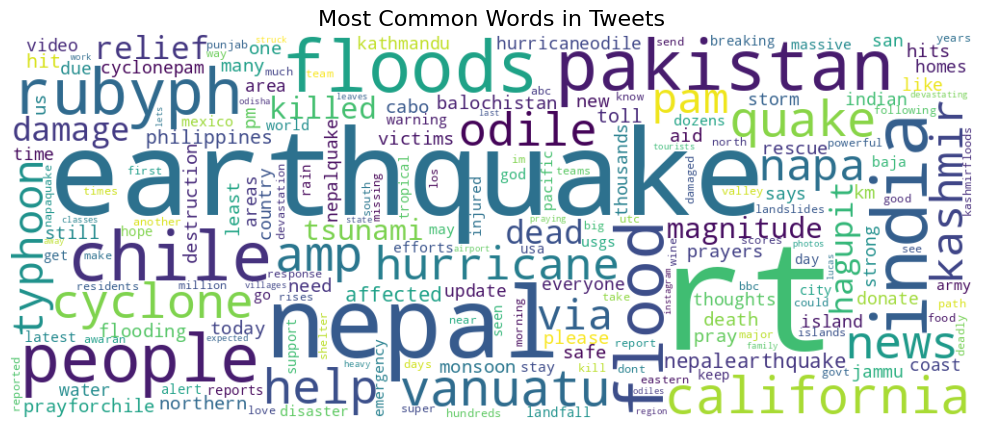

In [ ]:
# Word Cloud of Most Common Tokens
all_tokens = [token for tokens in df['tokens'] for token in tokens]
common_words = Counter(all_tokens)
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(common_words)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Tweets", fontsize=16)
plt.show()

In [ ]:
# show the merged dataset
df

,tweet_id,tweet_text,label,clean_text,tokens
0,'451190193488683009',RT @thebeautyblogca: Chilean coast evacuated #...,displaced_people_and_evacuations,rt thebeautyblogca chilean coast evacuated tsu...,"[rt, chilean, coast, evacuated, tsunami, warni..."
1,'501091102385254400',SPICE UP YA LIFE! RT @aemccarthy: Hold the fuc...,not_related_or_irrelevant,spice up ya life rt aemccarthy hold the fuckin...,"[spice, ya, life, rt, hold, fucking, phone, sp..."
2,'504292716650717184',Listage: Best Food Cinema Gems; Costly Napa Ea...,other_useful_information,listage best food cinema gems costly napa eart...,"[listage, best, food, cinema, gems, costly, na..."
3,'451327456264208384',RT @UniversalBN: https://t.co/fJUQlCseht #Chil...,other_useful_information,rt universalbn chile chileearthquake chilequak...,"[rt, chile, chileearthquake, chilequake, chile..."
4,'383421976213078016',150 trucks carrying supplies for #Balochistan ...,donation_needs_or_offers_or_volunteering_services,trucks carrying supplies for balochistan earth...,"[trucks, carrying, supplies, balochistan, eart..."
...,...,...,...,...,...
8686,'503811528596791296',How An Earthquake Will Mess Up Your Sleep: A J...,other_useful_information,how an earthquake will mess up your sleep jawb...,"[earthquake, mess, sleep, jawbone, chart, nort..."
8687,'499053388038815744',Govt faces flood of demands on Bharat Ratna ht...,other_useful_information,govt faces flood of demands on bharat ratna vi...,"[govt, faces, flood, demands, bharat, ratna, v..."
8688,'541485442218995712',RT @JohnMRoson: Lanslide reported along highwa...,infrastructure_and_utilities_damage,rt johnmroson lanslide reported along highway ...,"[rt, lanslide, reported, along, highway, san, ..."
8689,'512224103143833601',RT @MyMinhaj: #DrQadri:An inquiry commission w...,other_useful_information,rt myminhaj drqadrian inquiry commission was m...,"[rt, drqadrian, inquiry, commission, made, flo..."


In [ ]:
# Count rows before removal
before_removal = len(df)
print(f"Rows before removing empty-token entries: {before_removal}")

Rows before removing empty-token entries: 8691


In [ ]:
# Remove rows where 'tokens' list is empty
df = df[df['tokens'].map(lambda x: len(x) > 0)].reset_index(drop=True)

# Count rows after removal
after_removal = len(df)
print(f"Rows after removing empty-token entries: {after_removal}")

# Number of rows removed
removed = before_removal - after_removal
print(f"Total rows removed: {removed}")

Rows after removing empty-token entries: 8691
Total rows removed: 0


### Check label distribution

In [ ]:
# Basic distribution count
label_counts = df['label'].value_counts()

# Print distribution
print(label_counts)

label
other_useful_information                             2583
donation_needs_or_offers_or_volunteering_services    1226
injured_or_dead_people                               1161
not_related_or_irrelevant                            1115
sympathy_and_emotional_support                        943
infrastructure_and_utilities_damage                   697
caution_and_advice                                    505
displaced_people_and_evacuations                      273
missing_trapped_or_found_people                       188
Name: count, dtype: int64


In [ ]:
# Define the allowed labels
relevant_labels = [
    'injured_or_dead_people',
    'missing_trapped_or_found_people',
    'displaced_people_and_evacuations',
    'infrastructure_and_utilities_damage',
    'donation_needs_or_offers_or_volunteering_services',
    'caution_and_advice',
    'sympathy_and_emotional_support',
    'other_useful_information',
    'not_related_or_irrelevant'
]

# Filter the DataFrame
df = df[df['label'].isin(relevant_labels)].reset_index(drop=True)

# Check distribution again
label_counts = df['label'].value_counts()
print(label_counts)

label
other_useful_information                             5165
donation_needs_or_offers_or_volunteering_services    2452
injured_or_dead_people                               2321
not_related_or_irrelevant                            2230
sympathy_and_emotional_support                       1887
infrastructure_and_utilities_damage                  1394
caution_and_advice                                   1011
displaced_people_and_evacuations                      547
missing_trapped_or_found_people                       375
Name: count, dtype: int64


In [ ]:
# Save the data with 9 classes
df.to_csv(os.path.join(output_path,"data_with_classes.csv"), index=False)

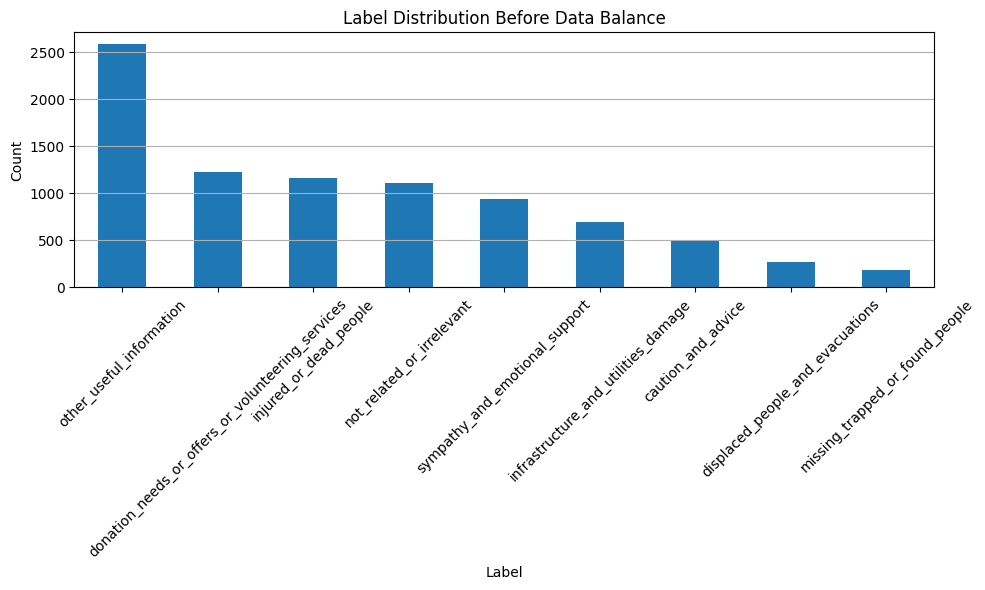

In [ ]:
# Plot distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Label Distribution Before Data Balance")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

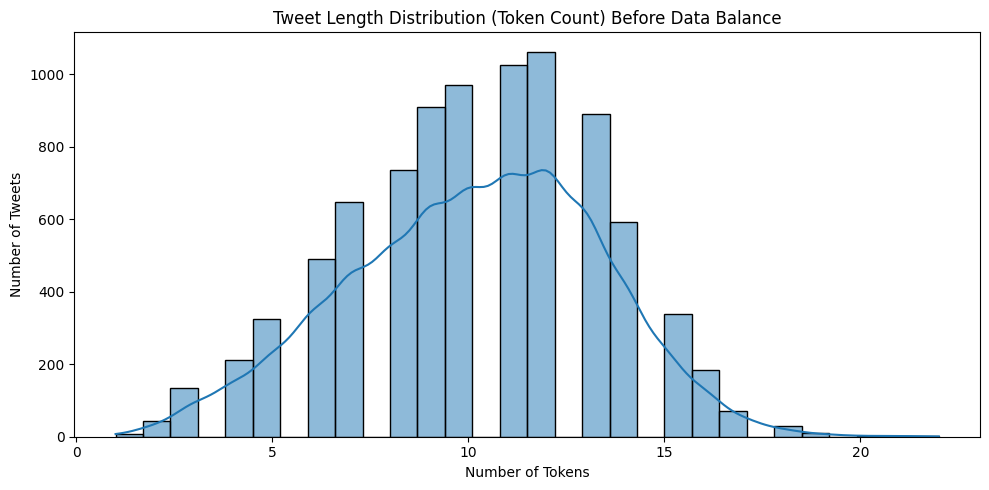

In [ ]:
# Tweet Length Distribution (in words)
df['tweet_length'] = df['tokens'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Tweet Length Distribution (Token Count) Before Data Balance")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()

## Balance the data

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Convert tokens list to string if not already done
df['text'] = df['tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))

# Vectorize for oversampling (used only for balancing purpose)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['label'])

# Oversample
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Recover resampled rows from original df
resampled_indices = ros.sample_indices_
df_balanced = df.iloc[resampled_indices].copy()
df_balanced['label_encoded'] = y_resampled
df_balanced['label'] = le.inverse_transform(y_resampled)

In [ ]:
# Check distribution again
label_counts_balance = df_balanced['label'].value_counts()
print(label_counts_balance)

label
displaced_people_and_evacuations                     2583
not_related_or_irrelevant                            2583
other_useful_information                             2583
donation_needs_or_offers_or_volunteering_services    2583
injured_or_dead_people                               2583
sympathy_and_emotional_support                       2583
caution_and_advice                                   2583
infrastructure_and_utilities_damage                  2583
missing_trapped_or_found_people                      2583
Name: count, dtype: int64


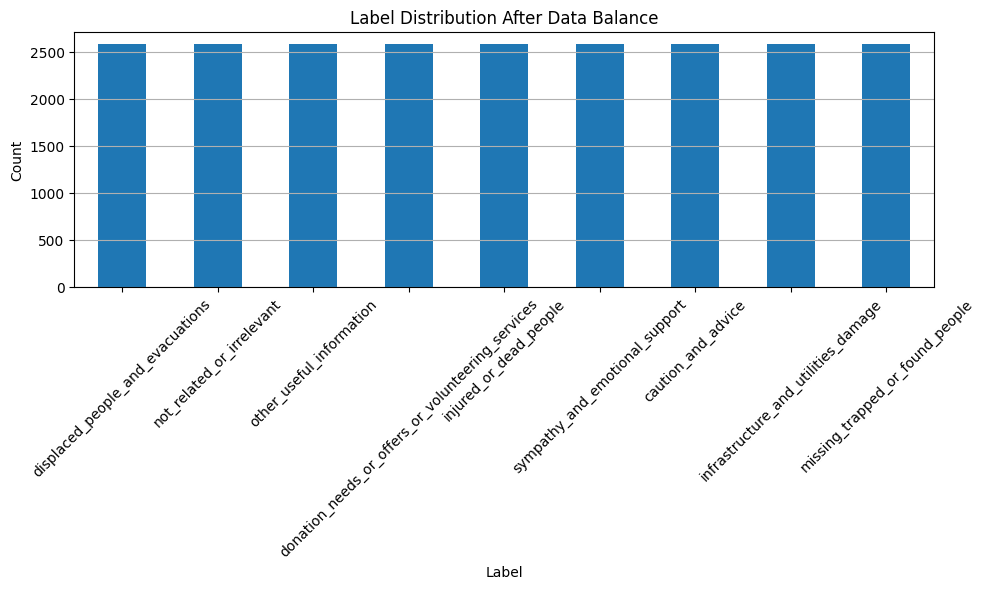

In [ ]:
# Plot distribution after balance
plt.figure(figsize=(10, 6))
label_counts_balance.plot(kind='bar')
plt.title("Label Distribution After Data Balance")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

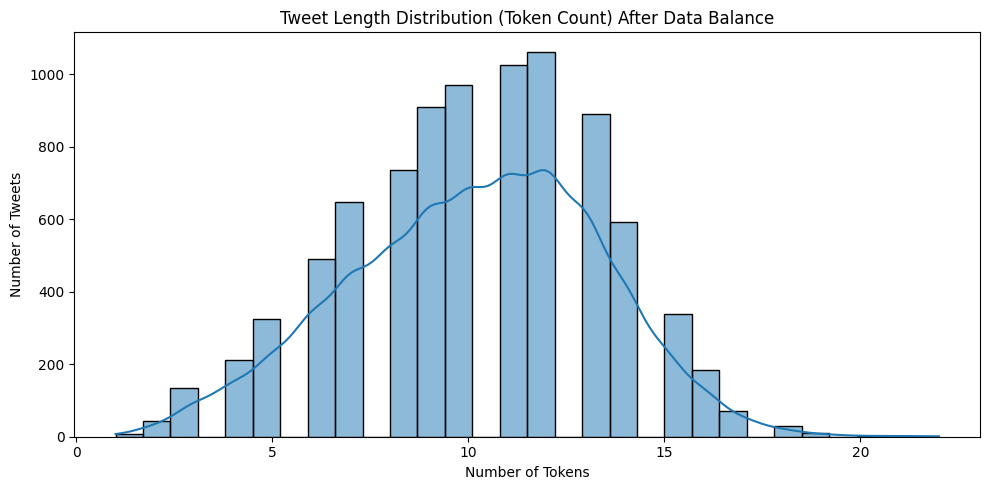

In [ ]:
# Tweet Length Distribution (in words)
df_balanced['tweet_length'] = df_balanced['tokens'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Tweet Length Distribution (Token Count) After Data Balance")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()

In [ ]:
# Save balance and clean dataset
df_balanced.to_csv(os.path.join(output_path, "balanced_disaster_dataset.csv"), index=False)

In [ ]:
df_balanced.columns

Index(['tweet_id', 'tweet_text', 'label', 'clean_text', 'tokens',
       'tweet_length', 'text', 'label_encoded'],
      dtype='object')

# Model Training and Evaluation Code

In [ ]:
# Load the merged dataset ===
file_path_model = os.path.join(output_path, "balanced_disaster_dataset.csv")
df_model = pd.read_csv(file_path_model, encoding='ISO-8859-1')
df_model

,tweet_id,tweet_text,label,clean_text,tokens,tweet_length,text,label_encoded
0,'451190193488683009',RT @thebeautyblogca: Chilean coast evacuated #...,displaced_people_and_evacuations,rt thebeautyblogca chilean coast evacuated tsu...,"['rt', 'chilean', 'coast', 'evacuated', 'tsuna...",8,rt chilean coast evacuated tsunami warning hou...,1
1,'501091102385254400',SPICE UP YA LIFE! RT @aemccarthy: Hold the fuc...,not_related_or_irrelevant,spice up ya life rt aemccarthy hold the fuckin...,"['spice', 'ya', 'life', 'rt', 'hold', 'fucking...",11,spice ya life rt hold fucking phone spice worl...,6
2,'504292716650717184',Listage: Best Food Cinema Gems; Costly Napa Ea...,other_useful_information,listage best food cinema gems costly napa eart...,"['listage', 'best', 'food', 'cinema', 'gems', ...",8,listage best food cinema gems costly napa eart...,7
3,'451327456264208384',RT @UniversalBN: https://t.co/fJUQlCseht #Chil...,other_useful_information,rt universalbn chile chileearthquake chilequak...,"['rt', 'chile', 'chileearthquake', 'chilequake...",8,rt chile chileearthquake chilequake chiletsuna...,7
4,'383421976213078016',150 trucks carrying supplies for #Balochistan ...,donation_needs_or_offers_or_volunteering_services,trucks carrying supplies for balochistan earth...,"['trucks', 'carrying', 'supplies', 'balochista...",10,trucks carrying supplies balochistan earthquak...,2
...,...,...,...,...,...,...,...,...
23242,'540812846460715008',"#RubyPH Guys, please be safe! :D",sympathy_and_emotional_support,rubyph guys please be safe,"['rubyph', 'guys', 'please', 'safe']",4,rubyph guys please safe,8
23243,'541476755156918274',Let's stay safe and continue praying as typhoo...,sympathy_and_emotional_support,lets stay safe and continue praying as typhoon...,"['lets', 'stay', 'safe', 'continue', 'praying'...",9,lets stay safe continue praying typhoon rubyph...,8
23244,'591909505841106944',My thoughts are with all our families @AutismC...,sympathy_and_emotional_support,my thoughts are with all our families autismca...,"['thoughts', 'families', 'autismspeaks', 'nepa...",4,thoughts families autismspeaks nepalearthquake,8
23245,'511710591833370625',Hoping @RockAndBrews San Jose is making it thr...,sympathy_and_emotional_support,hoping rockandbrews san jose is making it thro...,"['hoping', 'san', 'jose', 'making', 'odile', '...",12,hoping san jose making odile prayers everyone ...,8


## Traditional models

In [ ]:
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the label encoder
label_encoder = joblib.load(os.path.join(output_path, "models_label_encoder.pkl"))

# Show the label classes
print("Label classes:", label_encoder.classes_)
print("Available classes in label_encoder:", list(enumerate(label_encoder.classes_)))

Label classes: ['caution_and_advice' 'displaced_people_and_evacuations'
 'donation_needs_or_offers_or_volunteering_services'
 'infrastructure_and_utilities_damage' 'injured_or_dead_people'
 'missing_trapped_or_found_people' 'not_related_or_irrelevant'
 'other_useful_information' 'sympathy_and_emotional_support']
Available classes in label_encoder: [(0, 'caution_and_advice'), (1, 'displaced_people_and_evacuations'), (2, 'donation_needs_or_offers_or_volunteering_services'), (3, 'infrastructure_and_utilities_damage'), (4, 'injured_or_dead_people'), (5, 'missing_trapped_or_found_people'), (6, 'not_related_or_irrelevant'), (7, 'other_useful_information'), (8, 'sympathy_and_emotional_support')]


In [ ]:
# Drop any rows with missing values in 'clean_text' or 'label' just to be safe
df_model = df_model.dropna(subset=['clean_text', 'label'])

# Inputs and labels
X = df_model['clean_text']
y = df_model['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save label encoder
joblib.dump(label_encoder, os.path.join(output_path, "models_label_encoder.pkl"))

# Train-test split (stratified to maintain balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Save the vectorizer
joblib.dump(vectorizer, os.path.join(output_path, "tfidf_vectorizer.pkl"))

# Define traditional models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": LinearSVC(max_iter=1000)
}

In [ ]:
# Train, Evaluate and Store accuracies for all models
accuracies = {}

for name, model in models.items():
    print(f"\n====== {name} ======")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save model
    model_filename = os.path.join(output_path, f"{name.replace(' ', '_')}.pkl")
    joblib.dump(model, model_filename)


====== Logistic Regression ======
Accuracy: 0.8765591397849463
Classification Report:
                                                   precision    recall  f1-score   support

                               caution_and_advice       0.86      0.92      0.89       517
                 displaced_people_and_evacuations       0.94      0.98      0.96       516
donation_needs_or_offers_or_volunteering_services       0.84      0.92      0.88       517
              infrastructure_and_utilities_damage       0.87      0.90      0.88       517
                           injured_or_dead_people       0.94      0.93      0.94       517
                  missing_trapped_or_found_people       0.94      0.99      0.96       516
                        not_related_or_irrelevant       0.86      0.80      0.83       517
                         other_useful_information       0.69      0.56      0.62       516
                   sympathy_and_emotional_support       0.92      0.88      0.90       517

 

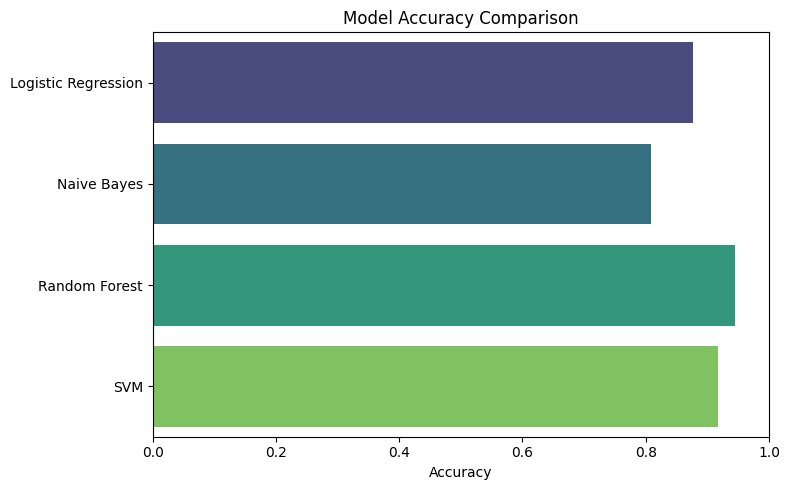

In [ ]:
# Plot accuracies of all models
plt.figure(figsize=(8, 5))
model_names = list(accuracies.keys())
model_scores = list(accuracies.values())
sns.barplot(x=model_scores, y=model_names, hue=model_names, palette='viridis', legend=False)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

### Sample Predictions

In [ ]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load unseen data
unseen_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project/output/unbalanced.csv")
texts = unseen_df['clean_text']

# Load vectorizer and label encoder
vectorizer = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project/output/tfidf_vectorizer.pkl")
le = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project/output/models_label_encoder.pkl")

In [ ]:
# Vectorize
X_unseen = vectorizer.transform(texts)

# Model paths
model_files = {
    "LR": "/content/drive/MyDrive/Colab Notebooks/Project/output/Logistic_Regression.pkl",
    "NB": "/content/drive/MyDrive/Colab Notebooks/Project/output/Naive_Bayes.pkl",
    "RF": "/content/drive/MyDrive/Colab Notebooks/Project/output/Random_Forest.pkl",
    "SVM": "/content/drive/MyDrive/Colab Notebooks/Project/output/SVM.pkl"
}

# Predict and save for each model
for name, path in model_files.items():
    model = joblib.load(path)
    y_pred = model.predict(X_unseen)
    pred_labels = y_pred

    result_df = pd.DataFrame({
        "clean_text": texts,
        "predicted_label": pred_labels
    })

    filename = os.path.join(output_path, f"{name}_predictions.csv")
    result_df.to_csv(filename, index=False)

    print(f"{name} predictions saved to {filename}")
    print(result_df.head())

LR predictions saved to /content/drive/MyDrive/Colab Notebooks/Project/output/LR_predictions.csv
                                          clean_text  \
0  hurricane odile strikes mexicos baja californi...   
1  rt mrazaharoon more dams and administrativeuni...   
2                oprah so what about earthquakenepal   
3  harrystyles can you send message of force to c...   
4  rt levimitchell prayers for philippines during...   

                    predicted_label  
0  displaced_people_and_evacuations  
1          other_useful_information  
2         not_related_or_irrelevant  
3         not_related_or_irrelevant  
4    sympathy_and_emotional_support  
NB predictions saved to /content/drive/MyDrive/Colab Notebooks/Project/output/NB_predictions.csv
                                          clean_text  \
0  hurricane odile strikes mexicos baja californi...   
1  rt mrazaharoon more dams and administrativeuni...   
2                oprah so what about earthquakenepal   
3  harrystyles ca

## LSTM Text Classification

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
# Encode labels
le = LabelEncoder()
df_model['label_encoded'] = le.fit_transform(df_model['label'])
joblib.dump(le, os.path.join(output_path, 'lstm_label_encoder.pkl'))

# Tokenization
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_model['clean_text'])
sequences = tokenizer.texts_to_sequences(df_model['clean_text'])
X = pad_sequences(sequences, maxlen=max_len)
y = df_model['label_encoded'].values

# Save tokenizer
joblib.dump(tokenizer, os.path.join(output_path, 'lstm_tokenizer.pkl'))

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 178s 323ms/step - accuracy: 0.3927 - loss: 1.6805 - val_accuracy: 0.8489 - val_loss: 0.4797
Epoch 2/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 201s 321ms/step - accuracy: 0.8741 - loss: 0.4413 - val_accuracy: 0.8968 - val_loss: 0.3285
Epoch 3/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 201s 319ms/step - accuracy: 0.9217 - loss: 0.2731 - val_accuracy: 0.9091 - val_loss: 0.3024
Epoch 4/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 202s 319ms/step - accuracy: 0.9513 - loss: 0.1731 - val_accuracy: 0.9247 - val_loss: 0.2751
Epoch 5/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 171s 326ms/step - accuracy: 0.9628 - loss: 0.1364 - val_accuracy: 0.9183 - val_loss: 0.3130


In [ ]:
# Save
model.save(os.path.join(output_path, 'lstm_model.keras'))

In [ ]:
# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)

print("Classification Report (LSTM):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step
Classification Report (LSTM):
                                                   precision    recall  f1-score   support

                               caution_and_advice       0.91      0.99      0.95       517
                 displaced_people_and_evacuations       0.99      1.00      0.99       516
donation_needs_or_offers_or_volunteering_services       0.90      0.95      0.92       517
              infrastructure_and_utilities_damage       0.95      0.97      0.96       517
                           injured_or_dead_people       0.94      0.96      0.95       517
                  missing_trapped_or_found_people       0.99      1.00      0.99       516
                        not_related_or_irrelevant       0.92      0.86      0.89       517
                         other_useful_information       0.80      0.70      0.75       516
                   sympathy_and_emotional_support       0.96      0.94      0.95       517

                

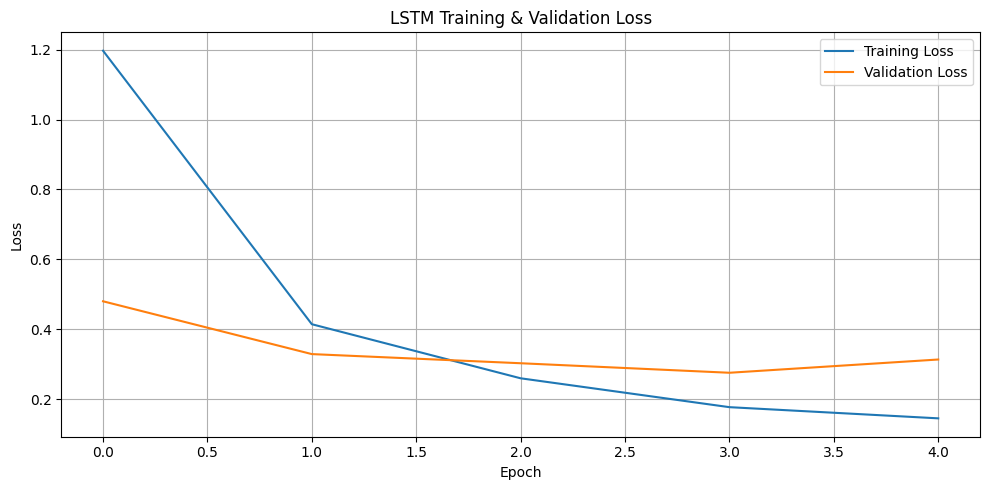

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

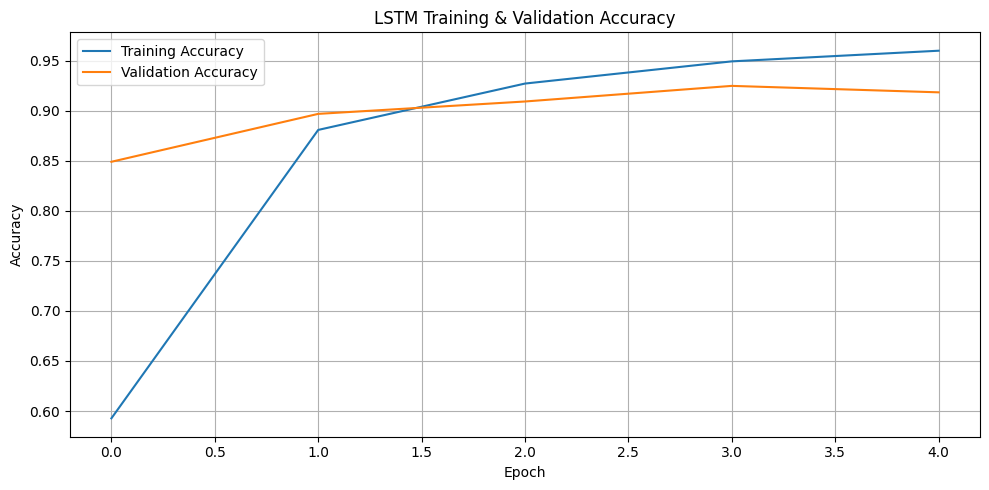

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("LSTM Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Sample Predictions

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load
model = load_model("/content/drive/MyDrive/Colab Notebooks/Project/output/lstm_model.keras")
tokenizer = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project/output/lstm_tokenizer.pkl")
le = joblib.load("/content/drive/MyDrive/Colab Notebooks/Project/output/lstm_label_encoder.pkl")

# Load unseen
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project/output/unbalanced.csv")
texts = df["clean_text"].astype(str)

In [ ]:
# Preprocess
sequences = tokenizer.texts_to_sequences(texts)
X_unseen = pad_sequences(sequences, maxlen=100)

# Predict
y_pred = np.argmax(model.predict(X_unseen), axis=1)
pred_labels = le.inverse_transform(y_pred)

272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step


In [ ]:
# Save and display
df_result = pd.DataFrame({
    "clean_text": texts,
    "predicted_label": pred_labels
})

df_result.to_csv("/content/drive/MyDrive/Colab Notebooks/Project/output/lstm_predictions.csv", index=False)
df_result.head()

,clean_text,predicted_label
0,hurricane odile strikes mexicos baja californi...,displaced_people_and_evacuations
1,rt mrazaharoon more dams and administrativeuni...,other_useful_information
2,oprah so what about earthquakenepal,not_related_or_irrelevant
3,harrystyles can you send message of force to c...,not_related_or_irrelevant
4,rt levimitchell prayers for philippines during...,sympathy_and_emotional_support
